In [1]:
#importing libraries
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
patient_files = [
    '1_a41178.mat', '2_a42126.mat', '3_a40076.mat',
    '4_a40050.mat', '5_a41287.mat', '6_a41846.mat',
    '7_a41846.mat', '8_a42008.mat', '9_a41846.mat']

train_data_list = []
test_data_list = []
label_train_list = []
label_test_list = []

def process_patient_data(patient_dict, train_ratio=2/3):
    """
    Process a loaded patient .mat file to extract and split data.
   
    Args:
        patient_dict (dict): Dictionary from scipy.io.loadmat
        train_ratio (float): Proportion of data to use for training
   
    Returns:
        train_data, test_data, label_train, label_test
    """
    all_data = np.floor(patient_dict['all_data']).astype(int)  # Floor to integer
    all_labels = patient_dict['all_labels'].flatten()  # Ensure labels are 1D

    num_samples = all_data.shape[1]
    split_index = int(num_samples * train_ratio)


    train_data = all_data[:, :split_index]
    test_data = all_data[:, split_index:]


    label_train = all_labels[:split_index]
    label_test = all_labels[split_index:]


    return train_data, test_data, label_train, label_test

# separate into training and testing data

for file in patient_files:
    patient_data = scipy.io.loadmat(file)
    train_data, test_data, label_train, label_test = process_patient_data(patient_data, train_ratio=2/3)

    train_data_list.append(train_data)
    test_data_list.append(test_data)
    label_train_list.append(label_train)
    label_test_list.append(label_test)



In [4]:
# calculate the prior probabilities P(H1), P(H0)
def calculate_priors(training_data):
    ph0 = 0.0 # probability that there is no patient abnormality (no alarm generated)
    ph1 = 0.0 # probability that there is a patient abnormality (alarm generated)

    for i in range(len(training_data)):
        if (training_data[i] == 1): # alarm generated
            ph1 += 1
        else: # no alarm generated
            ph0 += 1
    ph0 /= len(training_data)
    ph1 /= len(training_data)

    return [ph0, ph1]

priors = []
for arr in label_train_list:
    priors.append(calculate_priors(arr))

print(priors)

[[0.9734822051639916, 0.026517794836008374], [0.9836531627576404, 0.016346837242359632], [0.9979050279329609, 0.002094972067039106], [0.9975074775672981, 0.0024925224327018943], [0.9989539748953975, 0.0010460251046025104], [0.9782303370786517, 0.021769662921348316], [0.9828970331588133, 0.017102966841186736], [0.9922096317280453, 0.007790368271954674], [0.9782303370786517, 0.021769662921348316]]


In [5]:
# construct likelihood matrix
def likelihood_matrix(labels, data): # training data
    max_data = np.max(data) # get max of dataset
    min_data = np.min(data) # get min of dataset
    k_given_h1 = [] # first row of likelihood matrix, X=k given H1
    k_given_h0 = [] # second row of likelihood matrix, X=k given H0
    index = 0


    # get total count of H1 cases and H0 cases to calculate conditionals
    h1count = 0.0
    h0count = 0.0
    for i in range(len(labels)):
        if labels[i] == 1: # alarm generated, i.e., H1 occurrence
            h1count += 1.0
    h0count = len(labels) - h1count # all other values are 0, i.e., H0 occurrence


    for i in range(min_data, max_data + 1): # loop through all possible values
        k_given_h1.append(0.0)
        k_given_h0.append(0.0)
        for j in range(len(labels)): # for every alarm
            if (labels[j] == 1): # if alarm generated
                if data[j] == i: # and data coincides with alarm
                    k_given_h1[index] += 1.0 # increment k given H1 count
            else: # if no alarm generated
                if data[j] == i: # and data coincides with no alarm
                    k_given_h0[index] += 1.0 # increment k given H0 count
        index += 1
    for i in range(index): # normalize conditional probabilities according to total H1, H0 occurrences
        k_given_h1[i] /= h1count
        k_given_h0[i] /= h0count


    return [k_given_h1, k_given_h0] # likelihood matrix, first array is x=k given H1, second array is x=k given H0


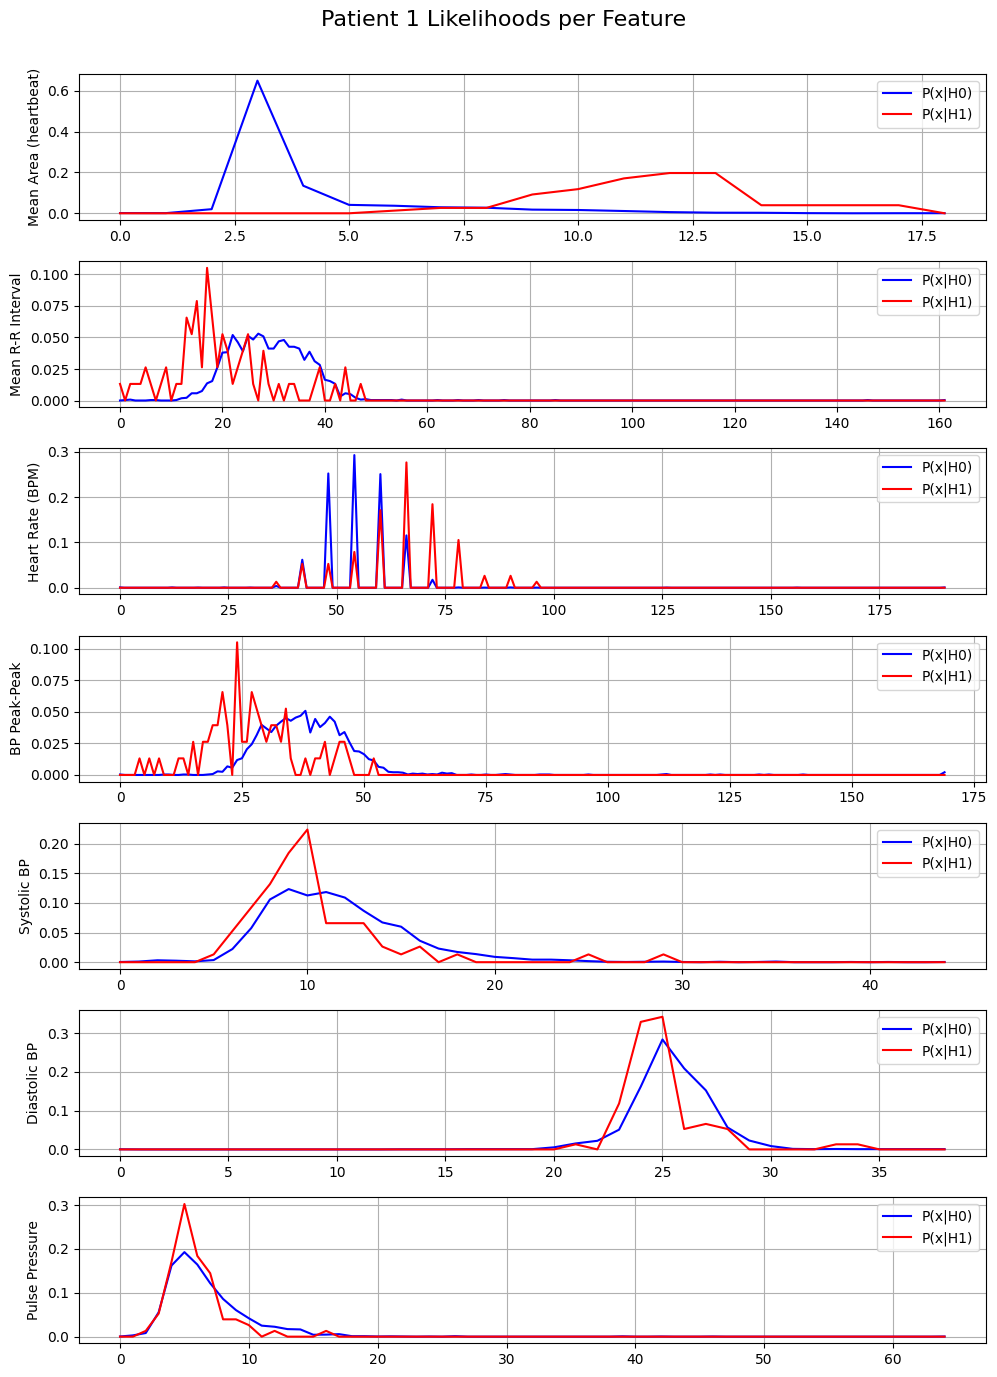

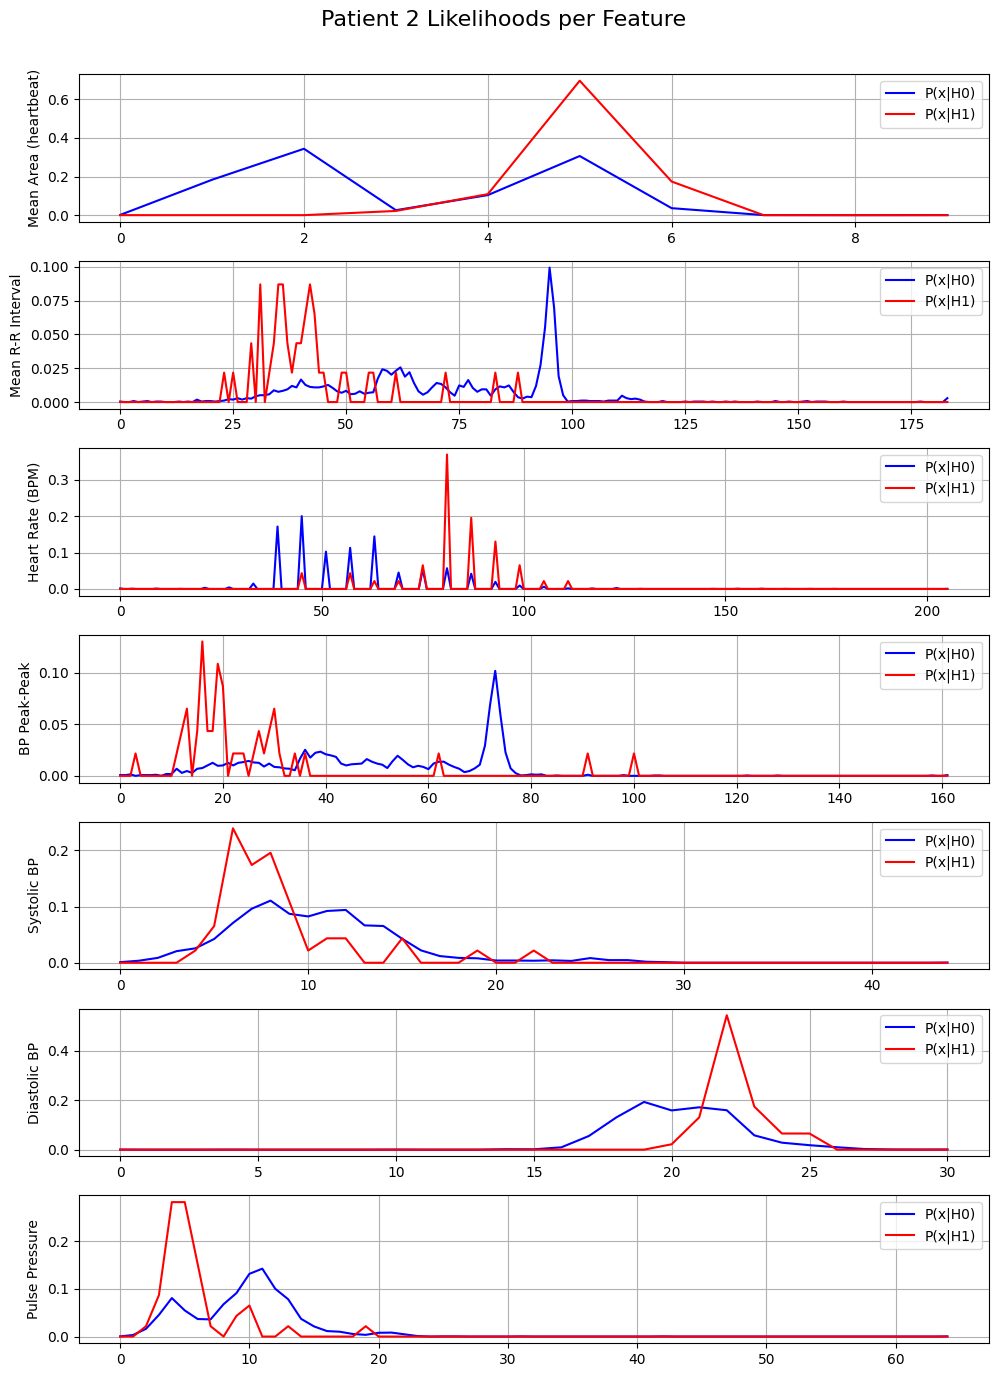

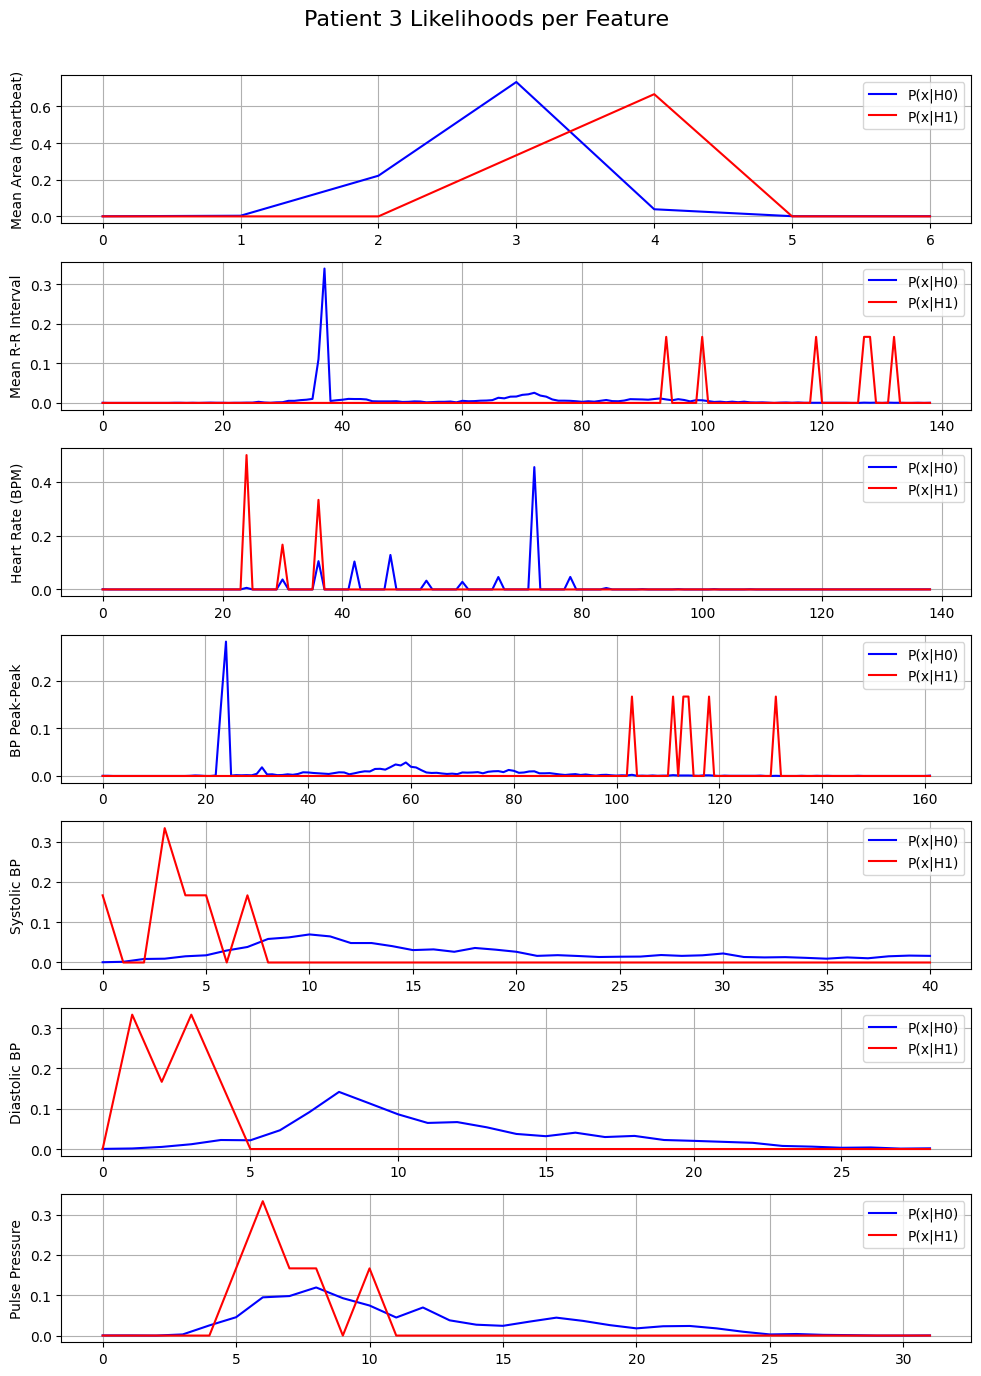

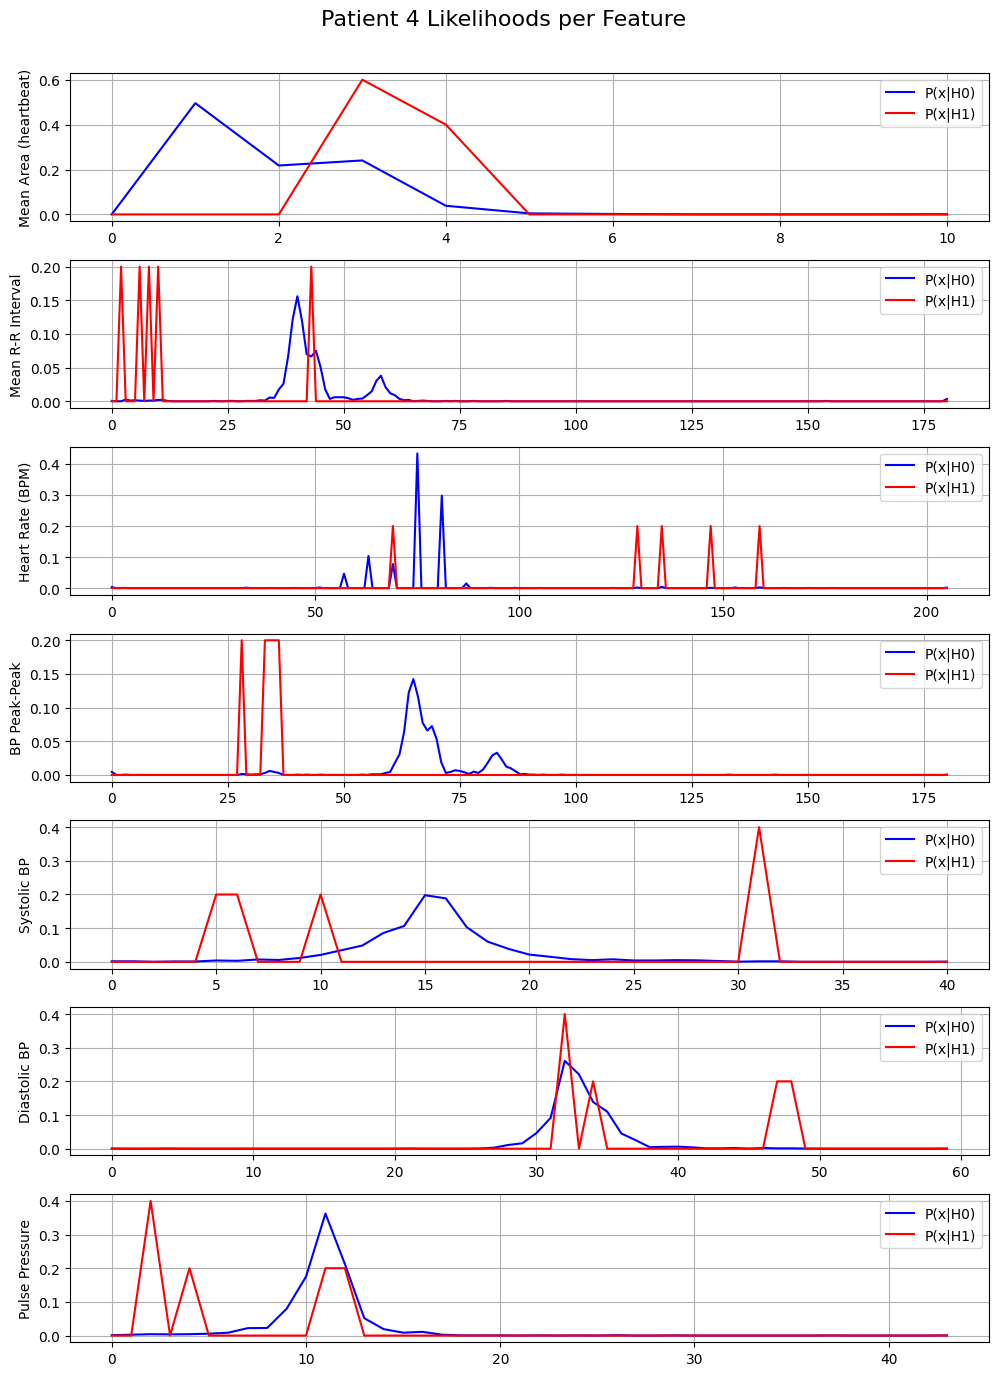

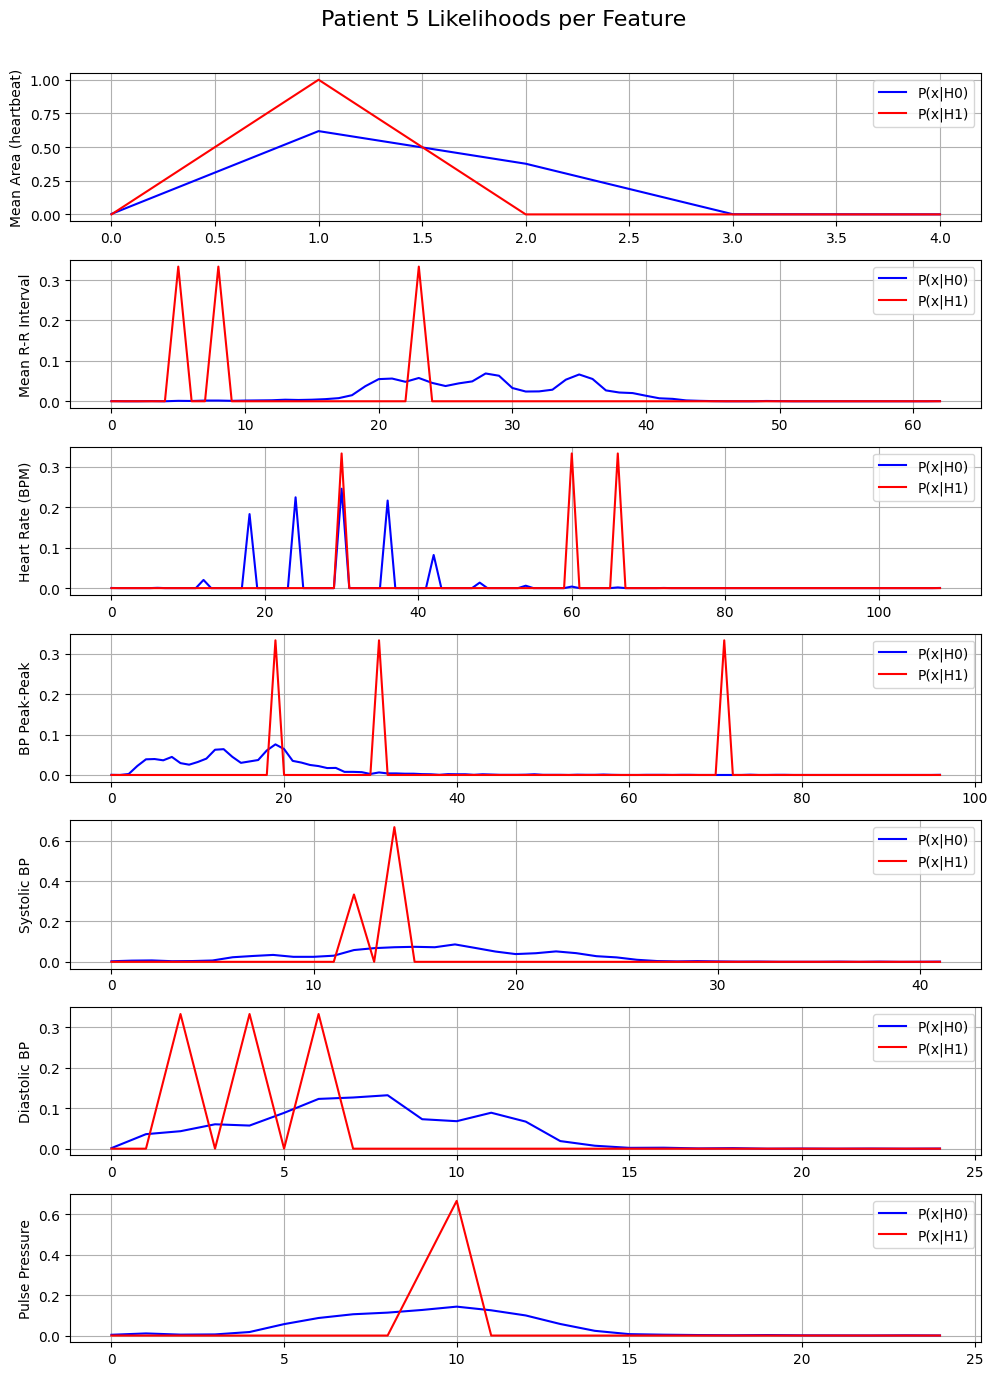

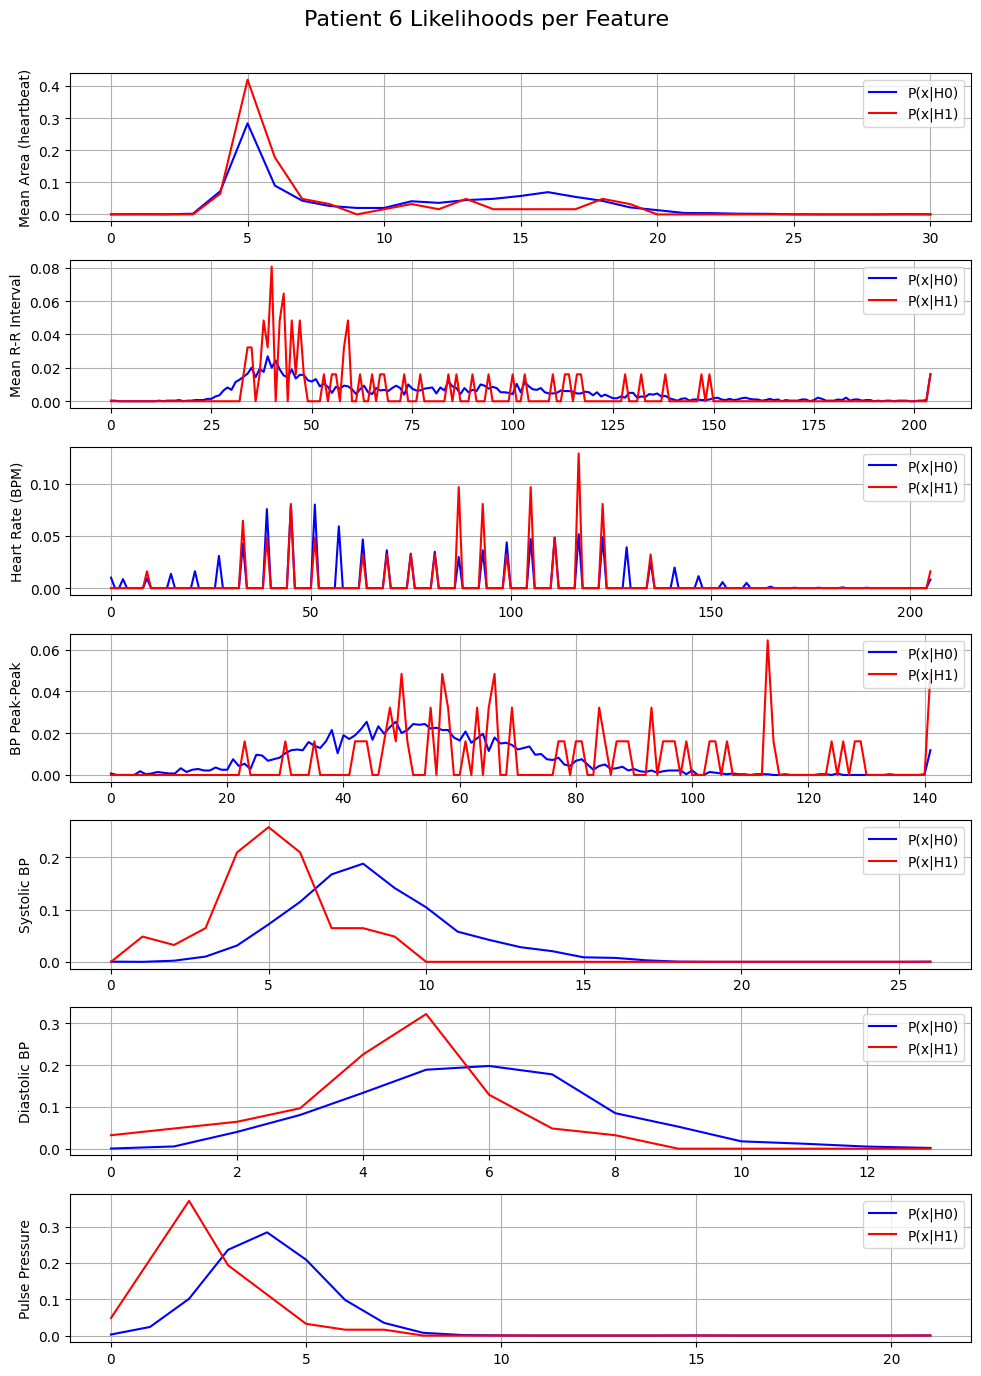

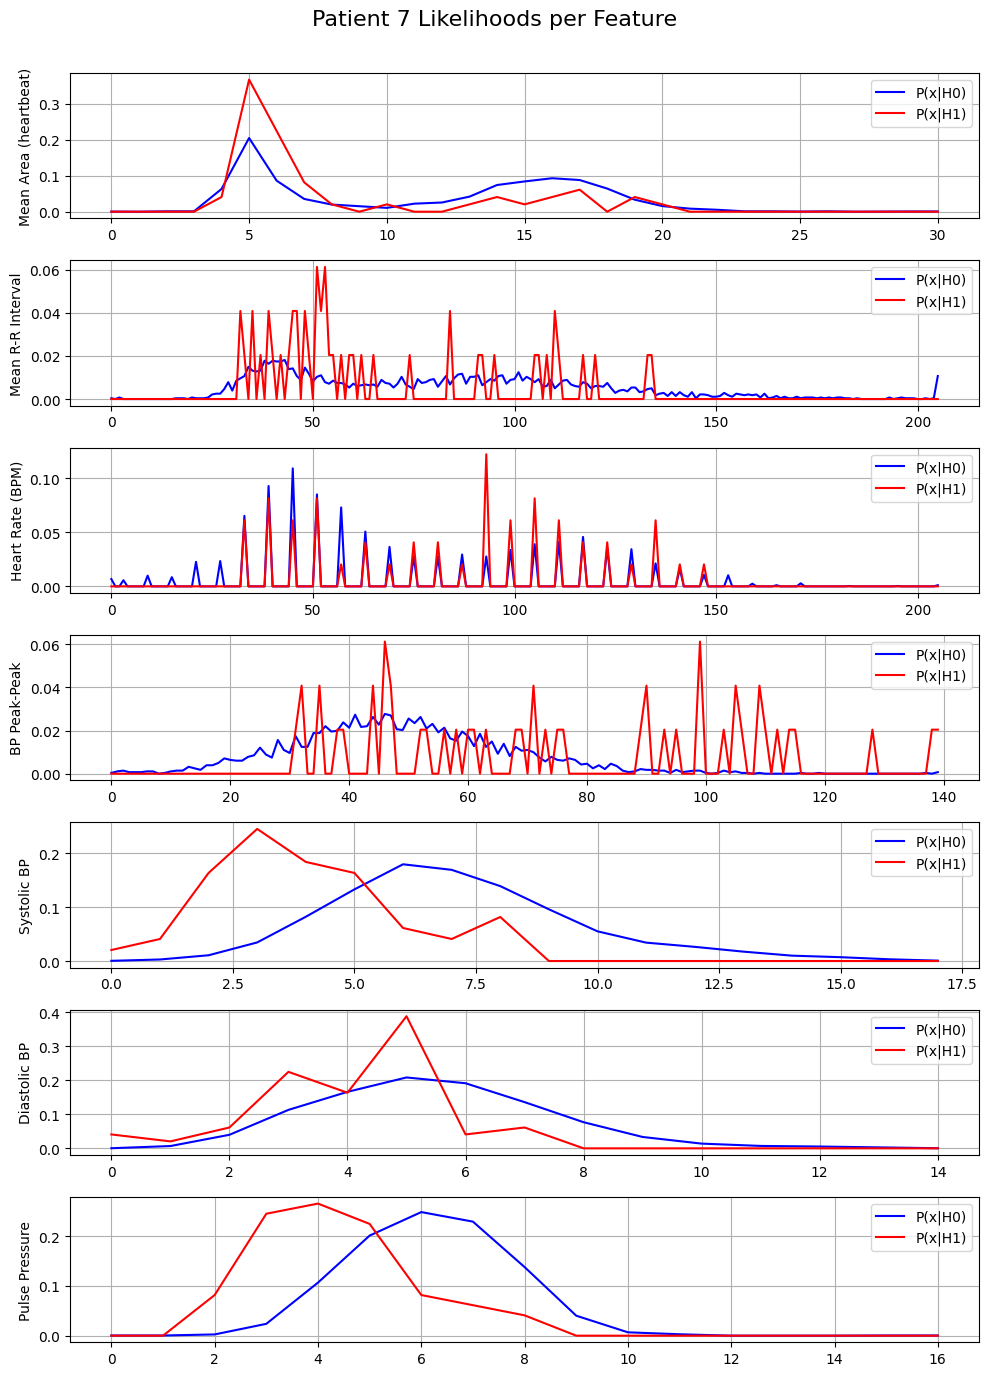

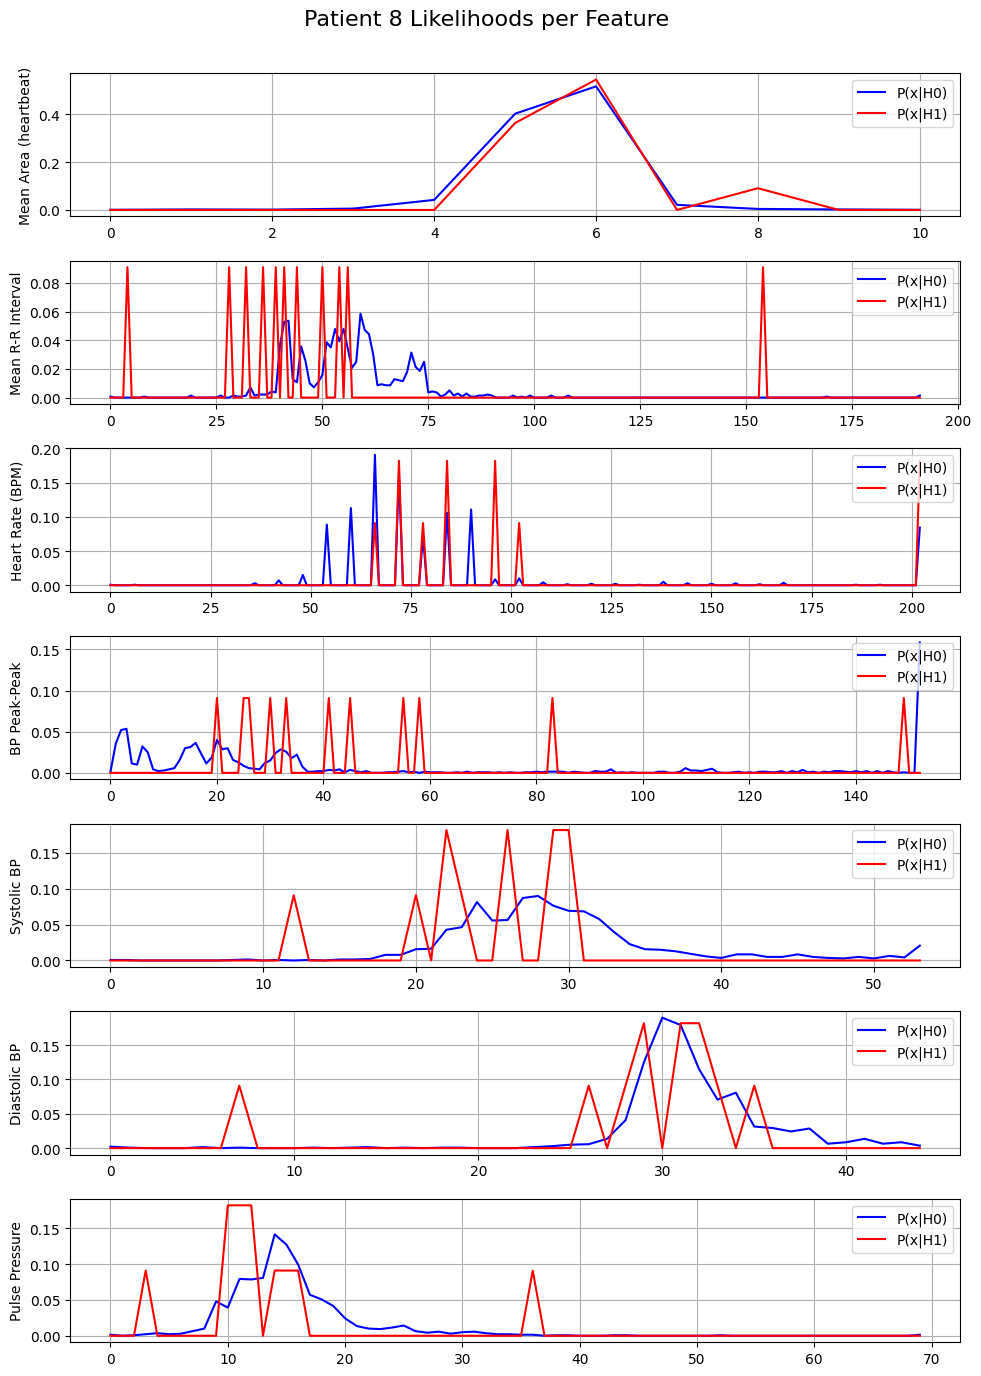

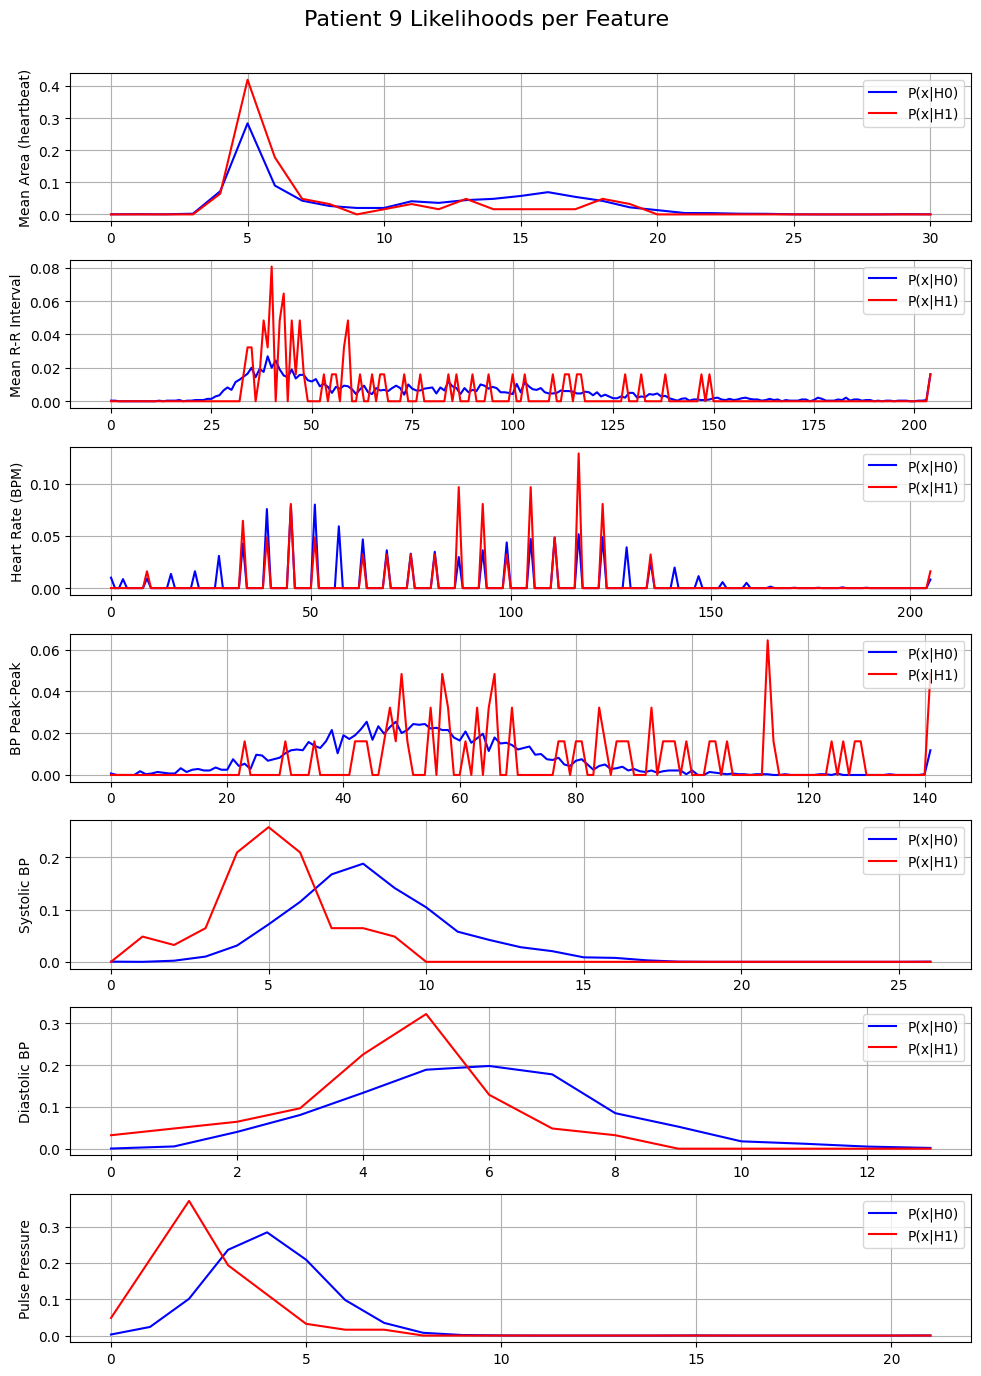

In [6]:
feature_names = ["Mean Area (heartbeat)", "Mean R-R Interval", "Heart Rate (BPM)",
    "BP Peak-Peak", "Systolic BP", "Diastolic BP", "Pulse Pressure"
]


h0andh1Vals = [[None for _ in range(7)] for _ in range(9)]


for i in range(9):  # For each patient
    fig, axs = plt.subplots(7, 1, figsize=(10, 14))  # 7 subplots


    for j in range(7):  # For each feature
        h1, h0 = likelihood_matrix(label_train_list[i], train_data_list[i][j])
        h0andh1Vals[i][j] = [h0,h1]
        axs[j].plot(h0, label='P(x|H0)', color='blue')
        axs[j].plot(h1, label='P(x|H1)', color='red')
        axs[j].set_ylabel(feature_names[j])
        axs[j].legend(loc='upper right')
        axs[j].grid(True)


    fig.suptitle(f"Patient {i+1} Likelihoods per Feature", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


In [7]:
#3.1 D
ML_vector = []
MAP_vector = []
for i in range(9): # for every patient
    ML_vector.append([])
    MAP_vector.append([])
    for j in range(7): # for every feature
        ML_vector[i].append([])
        MAP_vector[i].append([])
        for k in range(len(h0andh1Vals[i][j][0])): # length of h0
            ML_vector[i][j].append(0)
            MAP_vector[i][j].append(0)
            if(h0andh1Vals[i][j][0][k] <= h0andh1Vals[i][j][1][k]):
                ML_vector[i][j][k] = 1
            if (h0andh1Vals[i][j][0][k] * priors[i][0] <= h0andh1Vals[i][j][1][k] * priors[i][1]):
                MAP_vector[i][j][k] = 1
print(ML_vector)
print(MAP_vector)


[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [9]:
#3.1 E
min_data = [[0 for _ in range(7)] for _ in range(9)] #keep track of minimum indices for part e

for i in range(9):
    for j in range(7):
        min_data[i][j] = np.min(train_data_list[i][j]) # get min of dataset

HT_table_array = [[None for _ in range(7)] for _ in range(9)]
for i in range(9):
    for j in range(7):
        table = []
        length = len(ML_vector[i][j])
        for k in range(length):
            row = [
                k + min_data[i][j],                # i
                h0andh1Vals[i][j][1][k],           # P(x|H1)
                h0andh1Vals[i][j][0][k],           # P(x|H0)
                ML_vector[i][j][k],                # ML decision
                MAP_vector[i][j][k]                # MAP decision
            ]
            table.append(row)
        HT_table_array[i][j] = table
print(HT_table_array)


[[[[np.int64(-8), 0.0, 0.001075268817204301, 0, 0], [np.int64(-7), 0.0, 0.0007168458781362007, 0, 0], [np.int64(-6), 0.0, 0.02007168458781362, 0, 0], [np.int64(-5), 0.0, 0.6505376344086021, 0, 0], [np.int64(-4), 0.0, 0.13512544802867382, 0, 0], [np.int64(-3), 0.0, 0.04121863799283154, 0, 0], [np.int64(-2), 0.013157894736842105, 0.036917562724014336, 0, 0], [np.int64(-1), 0.02631578947368421, 0.02939068100358423, 0, 0], [np.int64(0), 0.02631578947368421, 0.02724014336917563, 0, 0], [np.int64(1), 0.09210526315789473, 0.017921146953405017, 1, 0], [np.int64(2), 0.11842105263157894, 0.016129032258064516, 1, 0], [np.int64(3), 0.17105263157894737, 0.011111111111111112, 1, 0], [np.int64(4), 0.19736842105263158, 0.005734767025089606, 1, 0], [np.int64(5), 0.19736842105263158, 0.002867383512544803, 1, 1], [np.int64(6), 0.039473684210526314, 0.0025089605734767025, 1, 0], [np.int64(7), 0.039473684210526314, 0.0007168458781362007, 1, 1], [np.int64(8), 0.039473684210526314, 0.0, 1, 1], [np.int64(9), 

In [11]:
#3.2 a
#min_data_test =  [[0 for _ in range(7)] for _ in range(9)] #keep track of minimum indices for test data instead of training
max_data = [[0 for _ in range(7)] for _ in range(9)]
for i in range(9):
    for j in range(7):
        #min_data_test[i][j] = np.min(test_data_list[i][j]) # get min of dataset
        max_data[i][j] = np.max(train_data_list[i][j])


ML_vector_test = [[None for _ in range(7)] for _ in range(9)]
MAP_vector_test = [[None for _ in range(7)] for _ in range(9)]
for i in range(9): # for every patient
    for j in range(7): # for every feature
        n = len(test_data_list[i][j]) # length of test data  
        ML_vector_test[i][j] = []
        MAP_vector_test[i][j] = []
        for k in range(n):
            index = test_data_list[i][j][k]-min_data[i][j]
            if (test_data_list[i][j][k] >= max_data[i][j]):
                index = max_data[i][j] - min_data[i][j]
            if (test_data_list[i][j][k] < min_data[i][j]):
                index = 0
            if(ML_vector[i][j][index] == 1): # ML generates an alarm for x=i
                ML_vector_test[i][j].append(1)
            else:
                ML_vector_test[i][j].append(0)
            if(MAP_vector[i][j][index] == 1): # MAP generates an alarm for x=i
                MAP_vector_test[i][j].append(1)
            else:
                MAP_vector_test[i][j].append(0)


In [ ]:
#3.2 b
Error_table_array = [[None for _ in range(7)] for _ in range(9)]

min_data_test =  [[0 for _ in range(7)] for _ in range(9)] #keep track of minimum indices for test data instead of training

for i in range(9):
    for j in range(7):
        min_data_test[i][j] = np.min(test_data_list[i][j]) # get min of dataset

for i in range(9):
    for j in range(7):
        ML_false_alarm = 0
        ML_missed_detection = 0
        MAP_false_alarm = 0
        MAP_missed_detection = 0
        ML_error = 0
        MAP_error = 0
        n = len(label_test_list[i])
        for k in range(n):
            index = test_data_list[i][j][k]-min_data[i][j]
            if (test_data_list[i][j][k] >= max_data[i][j]):
                index = max_data[i][j] - min_data[i][j]
            if (test_data_list[i][j][k] < min_data[i][j]):
                index = 0

            if(label_test_list[i][k] == 0 and ML_vector_test[i][j][index] == 1):
                ML_false_alarm = ML_false_alarm + 1
            if(label_test_list[i][k] == 1 and ML_vector_test[i][j][index] == 0):
                ML_missed_detection = ML_missed_detection + 1
            if(label_test_list[i][k] == 0 and MAP_vector_test[i][j][index] == 1):
                MAP_false_alarm = MAP_false_alarm + 1
            if(label_test_list[i][k] == 1 and MAP_vector_test[i][j][index] == 0):
                MAP_missed_detection = MAP_missed_detection + 1
        ML_false_alarm = ML_false_alarm/n
        ML_missed_detection = ML_missed_detection/n
        MAP_false_alarm = MAP_false_alarm/n
        MAP_missed_detection = MAP_missed_detection/n
        ML_error = ML_false_alarm*priors[i][0] + ML_missed_detection*priors[i][1]
        MAP_error = MAP_false_alarm*priors[i][0] + MAP_missed_detection*priors[i][1]
       
        Error_table_array[i][j] = [[ML_false_alarm, ML_missed_detection, ML_error],[MAP_false_alarm,MAP_missed_detection, MAP_error]]




In [13]:
#3.2 cont
best_features = []

for i in range(9):
    best_feature = [1,1] #ML and MAP
    p_error = [Error_table_array[i][0][0][2], Error_table_array[i][0][1][2]] #ML and MAP
   
    for j in range(1,7):
        ML_perror = Error_table_array[i][j][0][2]
        MAP_perror = Error_table_array[i][j][1][2]
        if(ML_perror < p_error[0]):
            best_feature[0] = j + 1
            p_error[0] = ML_perror
        if(MAP_perror < p_error[1]):
            best_feature[1] = j + 1
            p_error[1] = MAP_perror
    best_features.append(best_feature)


print(best_features)


# based on correlation calculation results, find next best ML/MAP errors for the 2nd, 3rd, 4th, and 5th patients
for i in range(1, 5):
    for j in range(7):
        print("ML ERROR FOR PATIENT " + str(i+1) + " AND FEATURE " + str(j+1) + ": " + str(Error_table_array[i][j][0][2]))
        print("MAP ERROR FOR PATIENT " + str(i+1) + " AND FEATURE " + str(j+1) + ": " + str(Error_table_array[i][j][1][2]))
    print("\n")


[[5, 1], [2, 1], [1, 1], [2, 1], [1, 1], [5, 1], [5, 1], [7, 1], [5, 1]]
ML ERROR FOR PATIENT 2 AND FEATURE 1: 0.9801600762421658
MAP ERROR FOR PATIENT 2 AND FEATURE 1: 5.804984816178846e-05
ML ERROR FOR PATIENT 2 AND FEATURE 2: 5.804984816178846e-05
MAP ERROR FOR PATIENT 2 AND FEATURE 2: 5.804984816178846e-05
ML ERROR FOR PATIENT 2 AND FEATURE 3: 5.804984816178846e-05
MAP ERROR FOR PATIENT 2 AND FEATURE 3: 5.804984816178846e-05
ML ERROR FOR PATIENT 2 AND FEATURE 4: 0.02101656894100924
MAP ERROR FOR PATIENT 2 AND FEATURE 4: 0.02101656894100924
ML ERROR FOR PATIENT 2 AND FEATURE 5: 0.8655868385345997
MAP ERROR FOR PATIENT 2 AND FEATURE 5: 5.804984816178846e-05
ML ERROR FOR PATIENT 2 AND FEATURE 6: 5.804984816178846e-05
MAP ERROR FOR PATIENT 2 AND FEATURE 6: 5.804984816178846e-05
ML ERROR FOR PATIENT 2 AND FEATURE 7: 5.804984816178846e-05
MAP ERROR FOR PATIENT 2 AND FEATURE 7: 5.804984816178846e-05


ML ERROR FOR PATIENT 3 AND FEATURE 1: 2.92593864111607e-06
MAP ERROR FOR PATIENT 3 AND F

In [14]:
# analyze correlation between pairs of features
correlation = [] # value [i][j] represents the correlation between feature i and feature j
for i in range(7):
    correlation.append([])
    for j in range(7):
        correlation[i].append(0)
        correlation[i][j] = float(np.corrcoef(train_data[i], train_data[j])[0, 1])


for i in range(len(correlation)):
    print("Correlation of feature " + str(i + 1))
    print(correlation[i])
    print("\n")


Correlation of feature 1
[0.9999999999999998, 0.7348739495445817, -0.7761076573913265, -0.19926278031080935, -0.02192282695261182, -0.35971529674640995, 0.4543738946377308]


Correlation of feature 2
[0.7348739495445817, 1.0, -0.845237552260763, -0.15717493293850676, 0.03422474341027523, -0.23930971730910866, 0.39300746557093347]


Correlation of feature 3
[-0.7761076573913264, -0.8452375522607631, 1.0, 0.24120685549601661, -0.021885646260516173, 0.2257103182526775, -0.3464207780784905]


Correlation of feature 4
[-0.19926278031080938, -0.15717493293850676, 0.24120685549601661, 1.0, -0.5597690371021227, -0.5727958636182939, -0.18468734933153866]


Correlation of feature 5
[-0.02192282695261182, 0.034224743410275225, -0.021885646260516176, -0.5597690371021227, 1.0, 0.8095401427937917, 0.6112082882207347]


Correlation of feature 6
[-0.3597152967464099, -0.23930971730910866, 0.22571031825267754, -0.5727958636182939, 0.8095401427937917, 0.9999999999999998, 0.07167032368930021]


Correlati

In [15]:
#4.1a~c
# from previous parts, we chose patients 3, 4, and 5
# for each of these patients, we chose features 2 and 5
def joint_observation(ht_table, patient, feature1, feature2):
    joint_HT_table = []


    table1 = ht_table[patient][feature1]
    table2 = ht_table[patient][feature2]


    for i in range(len(table1)):
        for j in range(len(table2)):
            jointH1 = table1[i][1] * table2[j][1]
            jointH0 = table1[i][2] * table2[j][2]
            jointML = 0 if jointH0 > jointH1 else 1
            jointMAP = 0 if jointH0*priors[patient][0] > jointH1*priors[patient][1] else 1
            row = [table1[i][0], table2[j][0], jointH1, jointH0, jointML, jointMAP]
            joint_HT_table.append(row)
    return joint_HT_table


[[[[np.int64(-8), 0.0, 0.001075268817204301, 0, 0], [np.int64(-7), 0.0, 0.0007168458781362007, 0, 0], [np.int64(-6), 0.0, 0.02007168458781362, 0, 0], [np.int64(-5), 0.0, 0.6505376344086021, 0, 0], [np.int64(-4), 0.0, 0.13512544802867382, 0, 0], [np.int64(-3), 0.0, 0.04121863799283154, 0, 0], [np.int64(-2), 0.013157894736842105, 0.036917562724014336, 0, 0], [np.int64(-1), 0.02631578947368421, 0.02939068100358423, 0, 0], [np.int64(0), 0.02631578947368421, 0.02724014336917563, 0, 0], [np.int64(1), 0.09210526315789473, 0.017921146953405017, 1, 0], [np.int64(2), 0.11842105263157894, 0.016129032258064516, 1, 0], [np.int64(3), 0.17105263157894737, 0.011111111111111112, 1, 0], [np.int64(4), 0.19736842105263158, 0.005734767025089606, 1, 0], [np.int64(5), 0.19736842105263158, 0.002867383512544803, 1, 1], [np.int64(6), 0.039473684210526314, 0.0025089605734767025, 1, 0], [np.int64(7), 0.039473684210526314, 0.0007168458781362007, 1, 1], [np.int64(8), 0.039473684210526314, 0.0, 1, 1], [np.int64(9), 

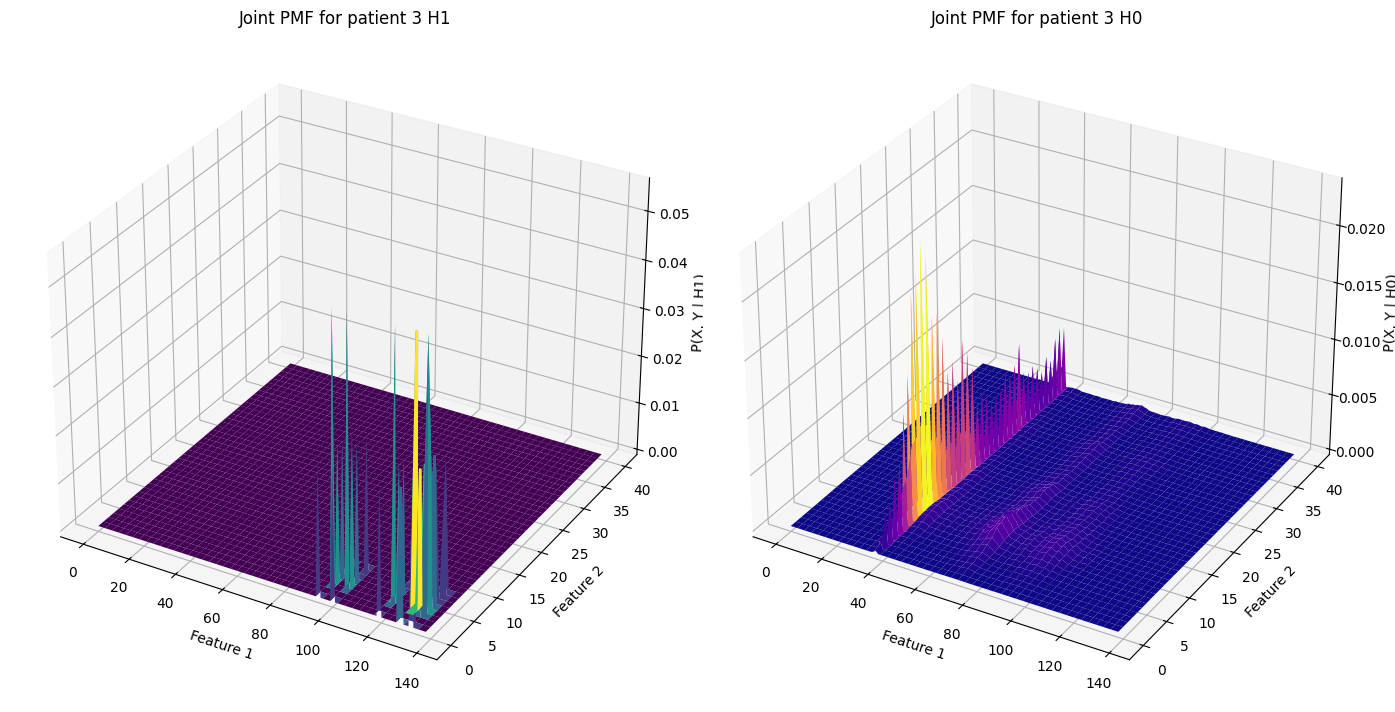

[[[[np.int64(-8), 0.0, 0.001075268817204301, 0, 0], [np.int64(-7), 0.0, 0.0007168458781362007, 0, 0], [np.int64(-6), 0.0, 0.02007168458781362, 0, 0], [np.int64(-5), 0.0, 0.6505376344086021, 0, 0], [np.int64(-4), 0.0, 0.13512544802867382, 0, 0], [np.int64(-3), 0.0, 0.04121863799283154, 0, 0], [np.int64(-2), 0.013157894736842105, 0.036917562724014336, 0, 0], [np.int64(-1), 0.02631578947368421, 0.02939068100358423, 0, 0], [np.int64(0), 0.02631578947368421, 0.02724014336917563, 0, 0], [np.int64(1), 0.09210526315789473, 0.017921146953405017, 1, 0], [np.int64(2), 0.11842105263157894, 0.016129032258064516, 1, 0], [np.int64(3), 0.17105263157894737, 0.011111111111111112, 1, 0], [np.int64(4), 0.19736842105263158, 0.005734767025089606, 1, 0], [np.int64(5), 0.19736842105263158, 0.002867383512544803, 1, 1], [np.int64(6), 0.039473684210526314, 0.0025089605734767025, 1, 0], [np.int64(7), 0.039473684210526314, 0.0007168458781362007, 1, 1], [np.int64(8), 0.039473684210526314, 0.0, 1, 1], [np.int64(9), 

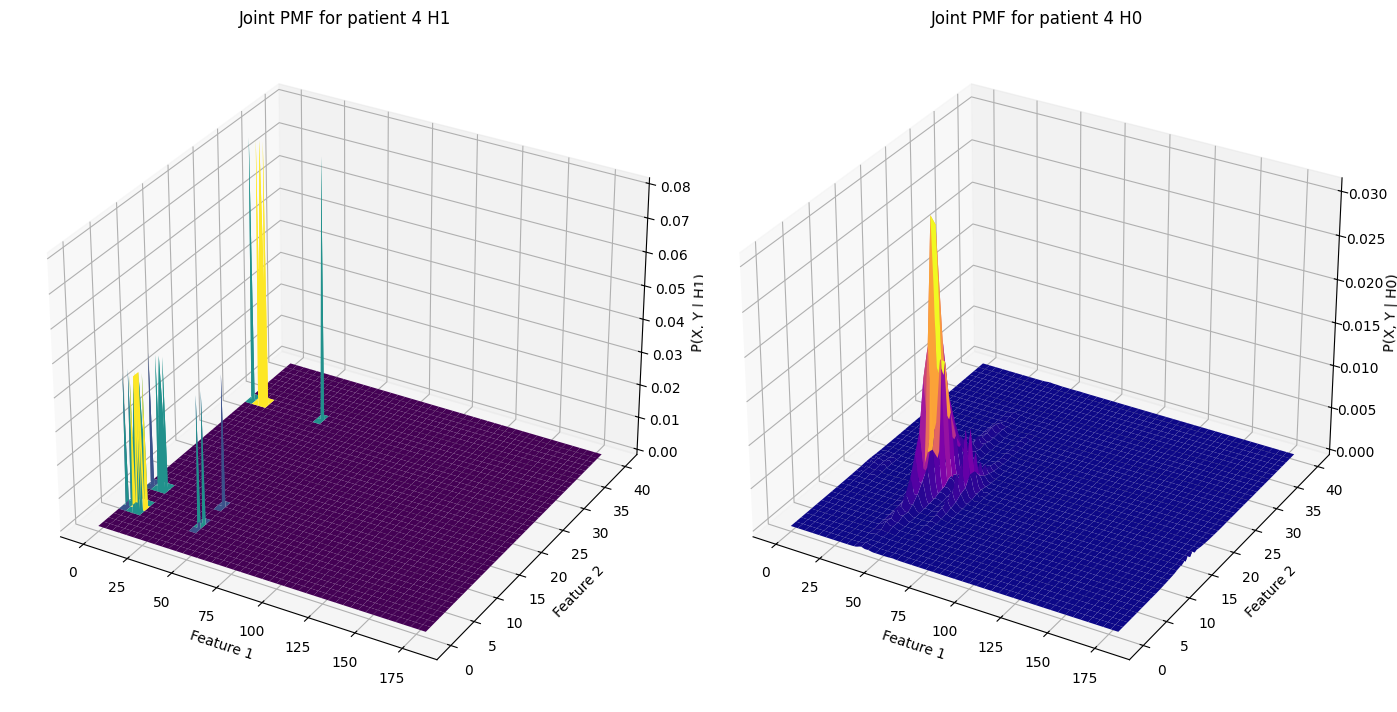

[[[[np.int64(-8), 0.0, 0.001075268817204301, 0, 0], [np.int64(-7), 0.0, 0.0007168458781362007, 0, 0], [np.int64(-6), 0.0, 0.02007168458781362, 0, 0], [np.int64(-5), 0.0, 0.6505376344086021, 0, 0], [np.int64(-4), 0.0, 0.13512544802867382, 0, 0], [np.int64(-3), 0.0, 0.04121863799283154, 0, 0], [np.int64(-2), 0.013157894736842105, 0.036917562724014336, 0, 0], [np.int64(-1), 0.02631578947368421, 0.02939068100358423, 0, 0], [np.int64(0), 0.02631578947368421, 0.02724014336917563, 0, 0], [np.int64(1), 0.09210526315789473, 0.017921146953405017, 1, 0], [np.int64(2), 0.11842105263157894, 0.016129032258064516, 1, 0], [np.int64(3), 0.17105263157894737, 0.011111111111111112, 1, 0], [np.int64(4), 0.19736842105263158, 0.005734767025089606, 1, 0], [np.int64(5), 0.19736842105263158, 0.002867383512544803, 1, 1], [np.int64(6), 0.039473684210526314, 0.0025089605734767025, 1, 0], [np.int64(7), 0.039473684210526314, 0.0007168458781362007, 1, 1], [np.int64(8), 0.039473684210526314, 0.0, 1, 1], [np.int64(9), 

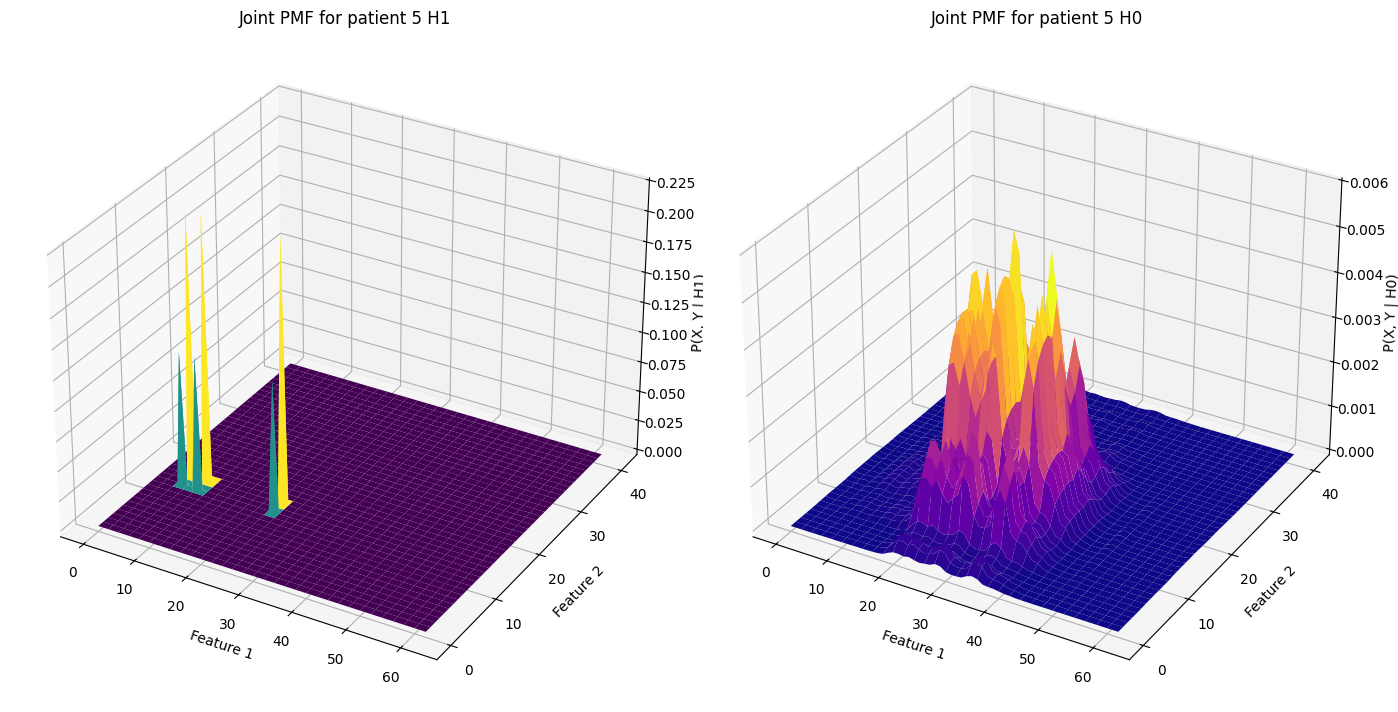

In [16]:
#4.1 d
def plot_joint(patient, feature1, feature2, HT_table_array):
    joint_HT_table = joint_observation(HT_table_array, patient, feature1, feature2)
    print(HT_table_array)


    # Initialize boundaries for X and Y values
    xmax = -float('inf')
    xmin = float('inf')
    ymax = -float('inf')
    ymin = float('inf')


    # Determine the minimum and maximum values for X and Y
    for row in joint_HT_table:
        i, j, jointH1, jointH0, jointML, jointMAP = row
        xmax = max(xmax, i)
        xmin = min(xmin, i)
        ymax = max(ymax, j)
        ymin = min(ymin, j)


    # Calculate the ranges for X and Y
    xrange = xmax - xmin + 1
    yrange = ymax - ymin + 1


    # Initialize pmf arrays with zeros
    pmf_h0 = np.zeros((xrange, yrange))
    pmf_h1 = np.zeros((xrange, yrange))


    # Create meshgrid for plotting
    x_vals = np.arange(xrange)
    y_vals = np.arange(yrange)
    X, Y = np.meshgrid(x_vals, y_vals, indexing='ij')


    # Populate pmf_h1 and pmf_h0 arrays based on joint_HT_table
    for row in joint_HT_table:
        i, j, jointH1, jointH0, jointML, jointMAP = row
        pmf_h1[i - xmin][j - ymin] = jointH1
        pmf_h0[i - xmin][j - ymin] = jointH0


    # Plotting
    fig = plt.figure(figsize=(14, 7))


    # Plot pmf under H1
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot_surface(X, Y, pmf_h1, cmap='viridis')
    ax1.set_title(f'Joint PMF for patient {patient + 1} H1')
    ax1.set_xlabel('Feature 1')
    ax1.set_ylabel('Feature 2')
    ax1.set_zlabel('P(X, Y | H1)')


    # Plot PMF under H0
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(X, Y, pmf_h0, cmap='plasma')
    ax2.set_title(f'Joint PMF for patient {patient + 1} H0')
    ax2.set_xlabel('Feature 1')
    ax2.set_ylabel('Feature 2')
    ax2.set_zlabel('P(X, Y | H0)')


    plt.tight_layout()
    plt.show()


#patient 3 features 2 and 5 (0 indexed)
plot_joint(2, 1, 4, HT_table_array)
#patient 4 features 2 and 5
plot_joint(3, 1, 4, HT_table_array)
#patient 5 features 2 and 5
plot_joint(4, 1, 4, HT_table_array)


In [17]:
#4.2
def error_arr(joint_HT_table, test_data_list, patient, feature1, feature2, label_test_list):
    f1 = test_data_list[patient][feature1] # i and j are arrays with the X and Y values to plug into Joint_HT_Table
    f2 = test_data_list[patient][feature2] #1d array x axis time, y axis value 0, 2 y values
   
    n=len(f2)
    jointML = [0 for _ in range(n)] #defaulting to 0, if i or j are outside the range of the training data, we say no alarm
    jointMAP = [0 for _ in range(n)]  #^^
    jointML = np.array(jointML)
    jointMAP = np.array(jointMAP)


    for x in range(n):
        #find the x and y in joint_HT_table
        for row in joint_HT_table:
            if(row[0] == f1[x] and row[1] == f2[x]):
                jointML[x] = row[4]
                jointMAP[x] = row[5]


    #b
    mlfalse = 0.0
    mlmiss = 0.0
    mapfalse = 0.0
    mapmiss = 0.0
    mlerror = 0.0
    maperror = 0.0


    n = len(label_test_list[patient])
    for i in range(n):
        if(label_test_list[patient][i] == 0.0 and jointML[i] == 1.0): # false alarm
            mlfalse = mlfalse + 1.0
        if(label_test_list[patient][i] == 1.0 and jointML[i] == 0.0): # miss detection
            mlmiss = mlmiss + 1.0
        if(label_test_list[patient][i] == 0.0 and jointMAP[i] == 1.0): # false alarm
            mapfalse = mapfalse + 1.0
        if(label_test_list[patient][i] == 1.0 and jointMAP[i] == 0.0): # miss detection
            mapmiss = mapmiss + 1.0
           
    mlfalse = mlfalse/float(n)
    mlmiss = mlmiss/float(n)
    mapfalse = mapfalse/float(n)
    mapmiss = mapmiss/float(n)
    mlerror = mlfalse*priors[patient][0] + ML_missed_detection*priors[patient][1]
    maperror = mapfalse*priors[patient][0] + mapmiss*priors[patient][1]
   
   
    secs = np.arange(n)
   
    # Plotting
    plt.figure(figsize=(15, 8))
    patientact = patient+1
    # Plot ML alarms
    plt.subplot(3, 1, 1)  # 3 rows, 1 column, first subplot
    plt.bar(secs, jointML, color='blue', width=2)
    plt.title(f"Patient {patientact} ML Alarms")
    plt.ylabel("Alarm (0=no alarm, 1=alarm)")
    plt.xlabel("Samples")
    plt.grid(True)
   
    # Plot MAP alarms
    plt.subplot(3, 1, 2)  # 3 rows, 1 column, second subplot
    plt.bar(secs, jointMAP, color='red', width=2)
    plt.title(f"Patient {patientact} MAP Alarms")
    plt.ylabel("Alarm (0=no alarm, 1=alarm)")
    plt.xlabel("Samples")
    plt.grid(True)
   
    # Plot Golden alarms
    plt.subplot(3, 1, 3)  # 3 rows, 1 column, third subplot
    plt.bar(secs, label_test_list[patient], color='green', width=2)
    plt.title(f"Patient {patientact} Golden Alarms")
    plt.ylabel("Alarm (0=no alarm, 1=alarm)")
    plt.xlabel("Samples")
    plt.grid(True)
   
    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()
   
    return [[mlfalse, mlmiss, mlerror], [mapfalse, mapmiss, maperror]]

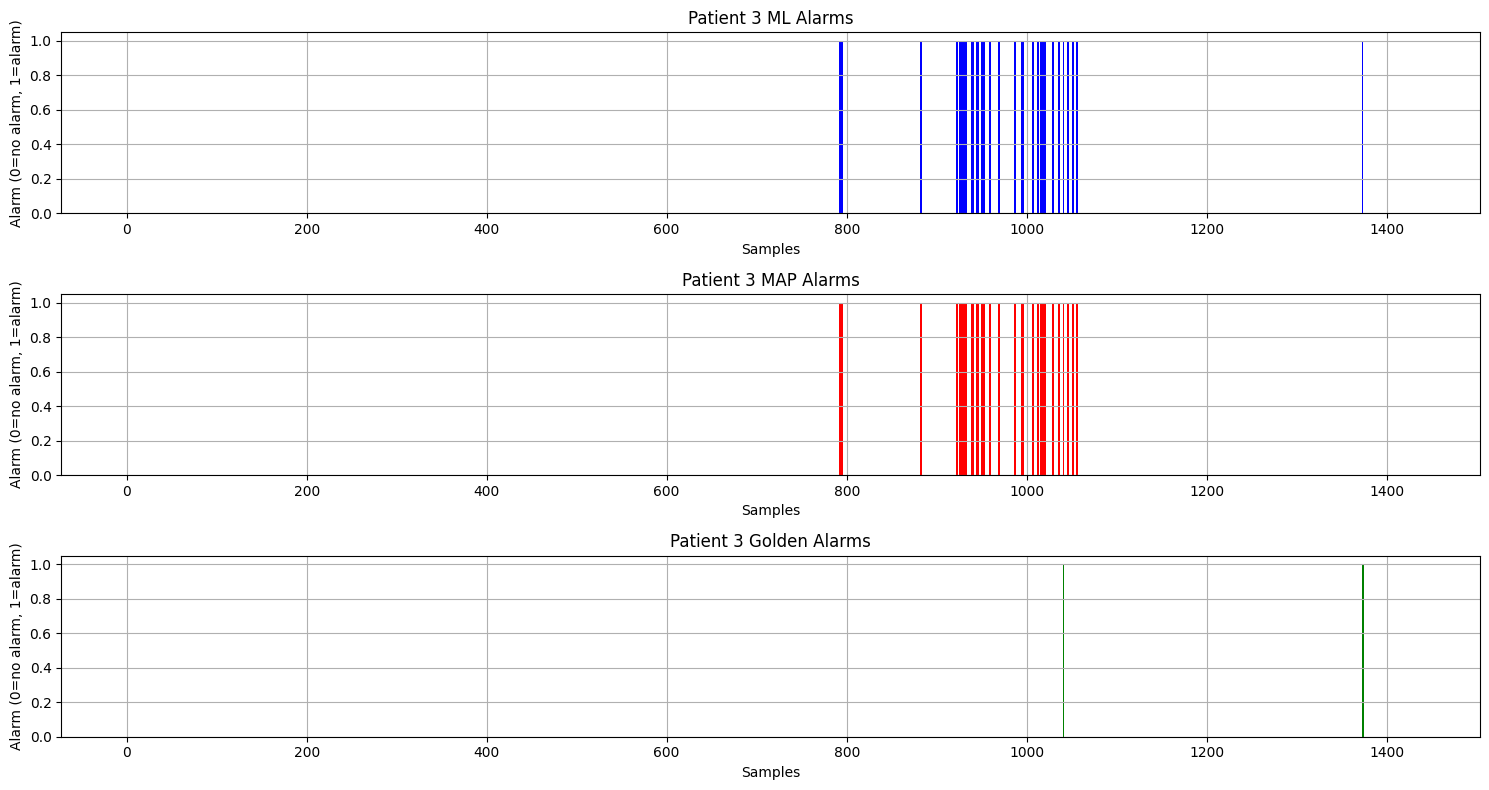

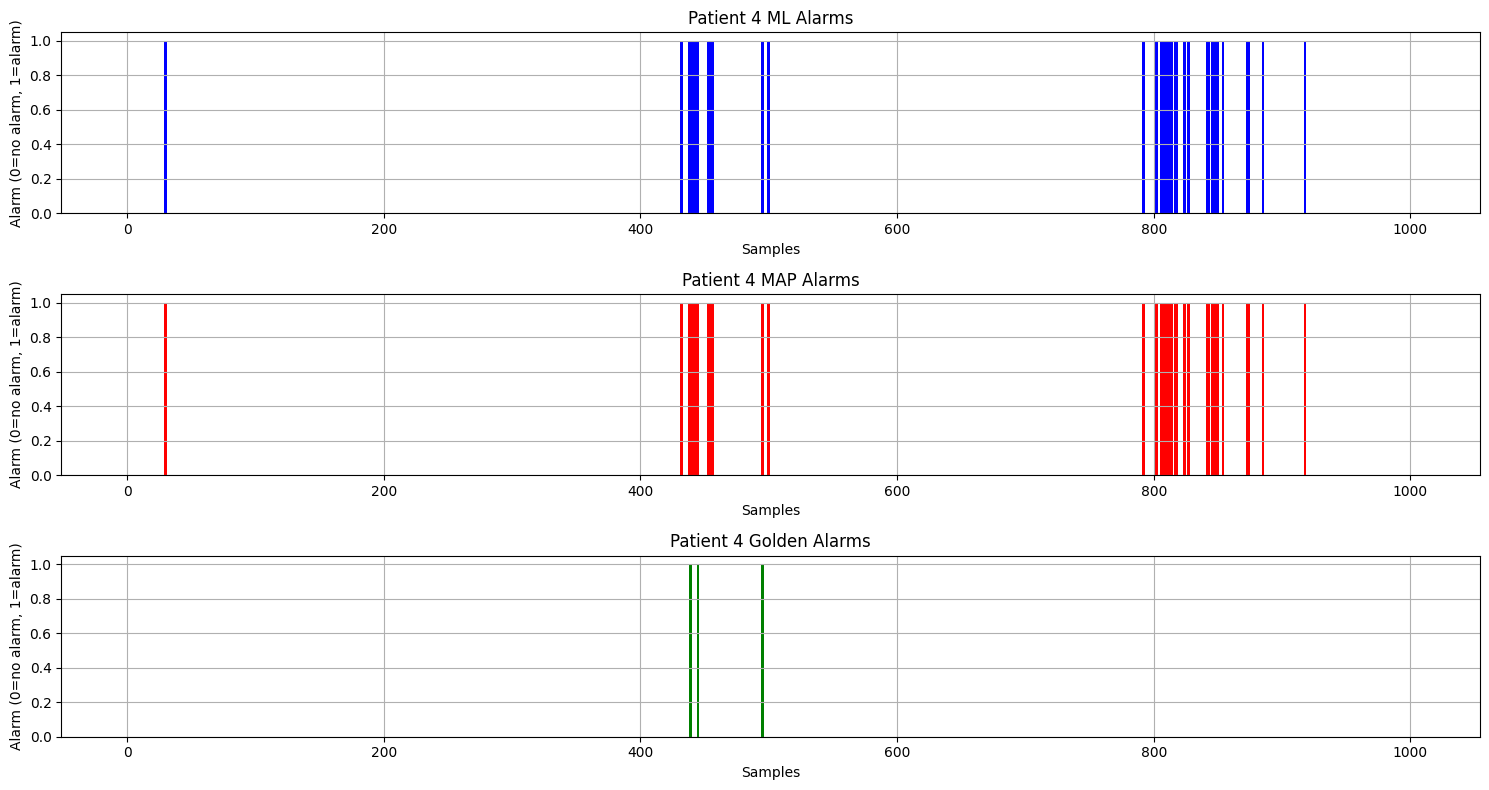

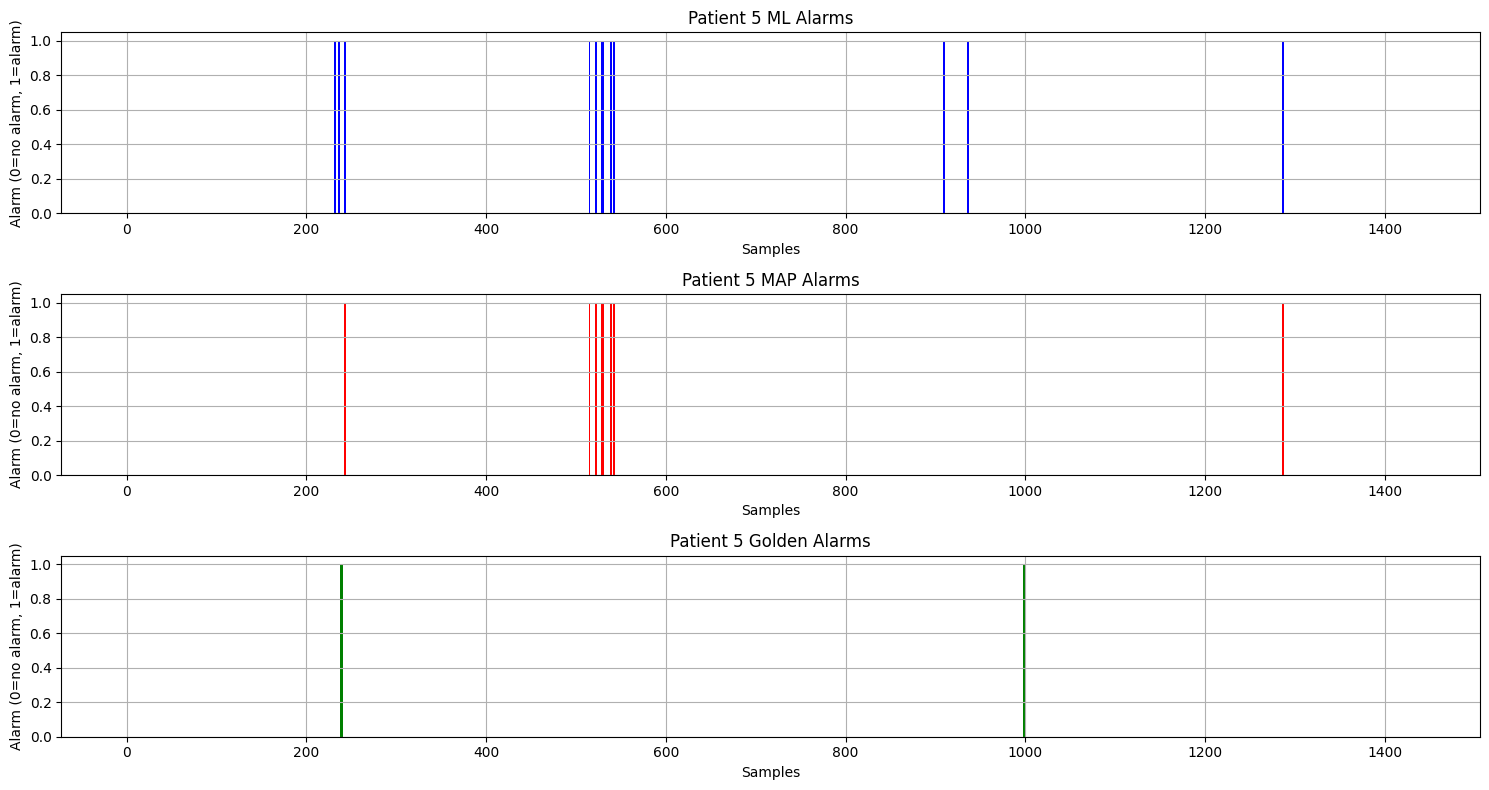

[[0.023044692737430168, 0.0006983240223463687, 0.02302434771074561], [0.0223463687150838, 0.0006983240223463687, 0.0223010166661465]]
[[0.036852589641434265, 0.0, 0.03679396736748586], [0.036852589641434265, 0.0, 0.03676073373504983]]
[[0.008368200836820083, 0.0020920502092050207, 0.008373394490059114], [0.005578800557880056, 0.0020920502092050207, 0.00557515332948186]]


In [20]:
#4.3
jp3 = joint_observation(HT_table_array, 2, 1, 4)
p3 = error_arr(jp3, test_data_list, 2, 1, 4, label_test_list)


jp4 = joint_observation(HT_table_array, 3, 1, 4)
p4 = error_arr(jp4, test_data_list, 3, 1, 4, label_test_list)


jp5 = joint_observation(HT_table_array, 4, 1, 4)
p5 = error_arr(jp5, test_data_list, 4, 1, 4, label_test_list)


print(p3)
print(p4)
print(p5)


# average error
avgmlerror = (p3[0][2]+ p4[0][2] + p5[0][2]) / 3.0
avgmaperror = (p3[1][2] + p4[1][2] + p5[1][2]) / 3.0
